<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning-KISD-2024/blob/main/lecture7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>




#**<font color = "red">Introduction to machine learning</font>**

**Lecture 7 (and the last)**


#**<font color = "green">Autoencoders and stable diffusion generators</font>**

*8 May 2024*


---

*Marcin Wolter, IFJ PAN*

*e-mail: marcin.wolter@ifj.edu.pl*


---
</center>

#<font color='green'>**Program for today:**


* ###  <font color='red'>Autoencoders
* ###  <font color='red'>Stable diffusion algorithm

<br>


**As always all slides are here:**

*https://github.com/marcinwolter/MachineLearning-KISD-2024*

<br>




# <font color='green'> **Autoencoders**

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. The autoencoder learns an efficient representation (encoding) for a set of data, typically for dimensionality reduction.

<img src='https://stackabuse.s3.amazonaws.com/media/image-reconstruction-and-denoising-with-autoencoders-in-python-and-keras-3.png' width=500px>

# **Simple autoencoder**

In [20]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [21]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D,Conv2DTranspose
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics

# Read MNIST data

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
x_train = x_train / 255.
x_test = x_test / 255.

# Hyperparameters

In [23]:
encoding_dim = 2
batch_size = 128
epochs = 50 #200

 # Build autoencoder



In [24]:

# This is our input image
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dropout(0.05)(encoded)
encoded = Dense(encoding_dim, activation='linear')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dropout(0.05)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

autoencoder.summary()
encoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 512)               1315

# Train the autoencoder

In [25]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 7s 7ms/step - loss: 0.2357 - val_loss: 0.2011
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1961 - val_loss: 0.1904
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1884 - val_loss: 0.1842
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1838 - val_loss: 0.1810
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1807 - val_loss: 0.1783
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1784 - val_loss: 0.1764
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1766 - val_loss: 0.1759
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1753 - val_loss: 0.1736
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1739 - val_loss: 0.1726
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1730 - val_loss: 0.1714

# Plot history

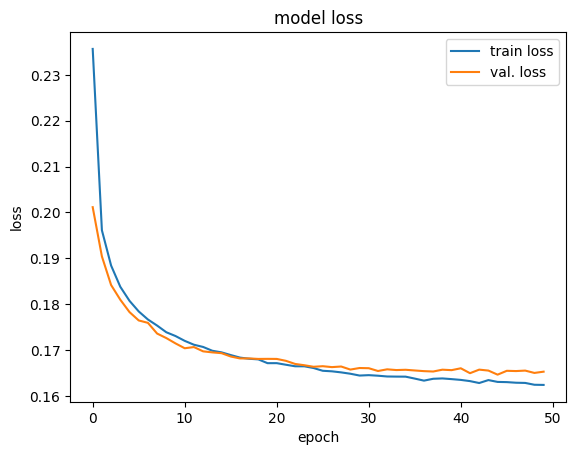

In [26]:
# summarize history for loss
import matplotlib.pyplot as plt

print(history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','val. loss'], loc='upper right')
plt.show()

# Plot clusters

(None, 2) (10000, 784) (10000,)
313/313 [==============================] - 1s 2ms/step
(10000, 2)


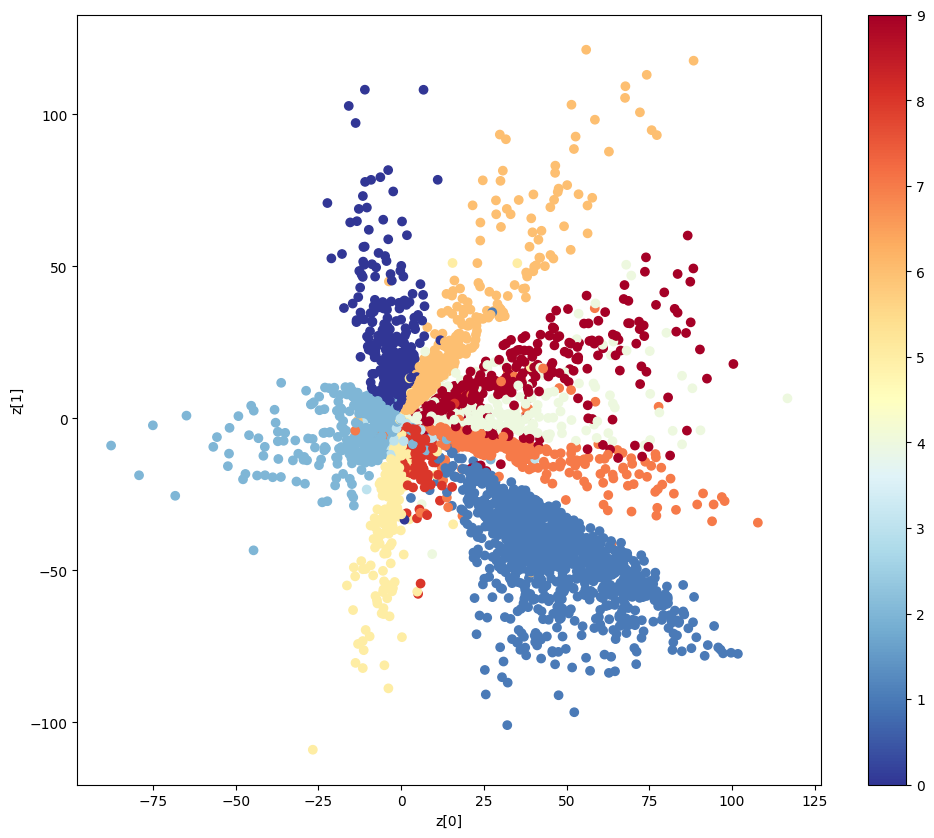

In [28]:
import matplotlib.pyplot as plt

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(data.reshape(len(data),784))
    print(z.shape)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="RdYlBu_r")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



print(encoded.shape,x_test.shape,y_test.shape)
plot_label_clusters(encoder, x_test, y_test)

# Plot digits

313/313 [==============================] - 1s 3ms/step


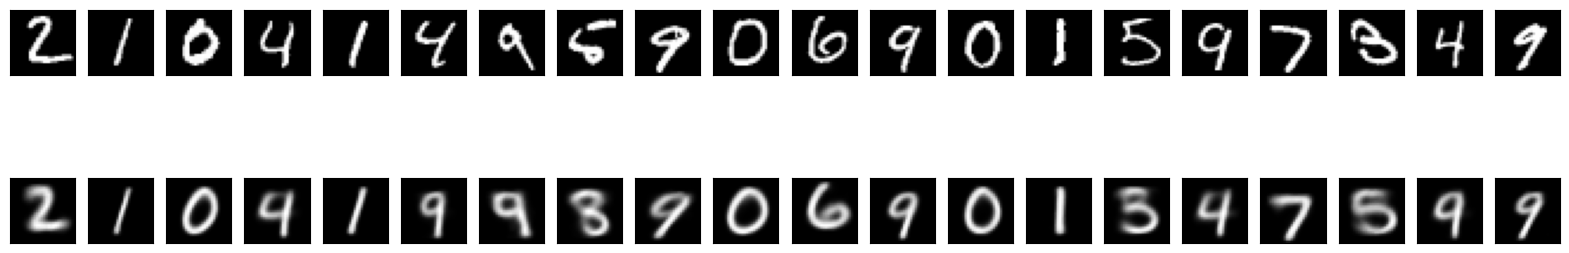

In [29]:
decoded_imgs = autoencoder.predict(x_test)

n = 20
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Can you see any failures in the decoded digits above?

# **What else could we do with autoencoders?**

### For example: <font color='green'>image denoising.


#**Denoising Autoencoders (DAE)**
 In the case of a Denoising Autoencoder, the data is partially corrupted by noises added to the input vector in a stochastic manner. Then, the model is trained to predict the original, uncorrupted data point as its output.

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/0*ECdHu2yeal38Jl3P.png' width=700px>

Let’s explain the training process at stake here.

* An input is sampled from our dataset.
* A corrupted version of this input is sampled from a stochastic mapping M( ̃x|x)
* (x, ̃x) is used as a training example

# Autoencoder for image denoising

**Author:** [Santiago L. Valdarrama](https://twitter.com/svpino)<br>
Modified by M.Wolter<br>
**Date created:** 2021/03/01<br>
**Last modified:** 2023/04/17<br>
**Description:** How to train a deep convolutional autoencoder for image denoising.

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.8
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()



def display3(array1, array2, array3):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 6))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(image3.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()




## Prepare the data

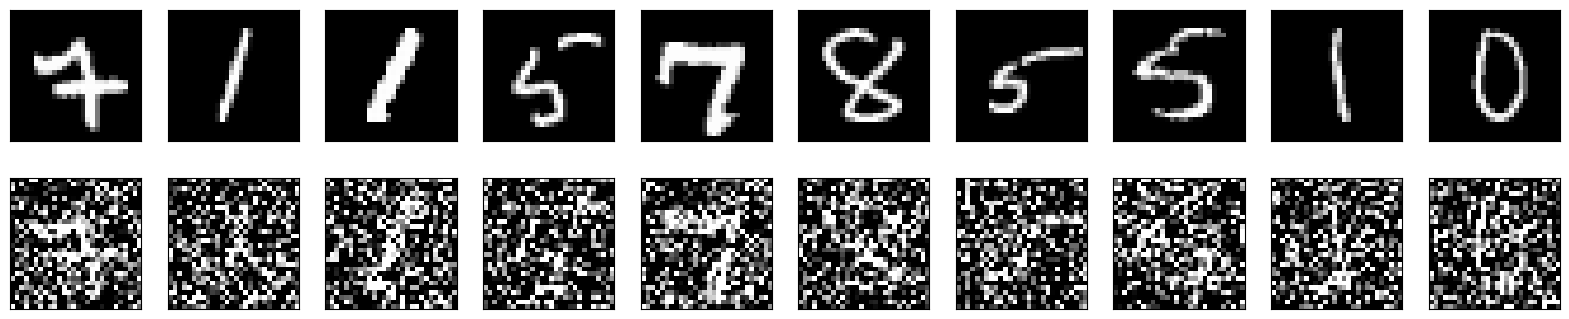

In [11]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our autoencoder.

# **Fully connected autoencoder**

In [12]:
encoding_dim = 10

# reshape data (28,28,1)->(784)
train_data = train_data.reshape(-1,784)
test_data = test_data.reshape(-1,784)
noisy_train_data = noisy_train_data.reshape(-1,784)
noisy_test_data = noisy_test_data.reshape(-1,784)

# This is our input image
input_img = layers.Input(shape=(784))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dropout(0.05)(encoded)
encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(256, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dropout(0.05)(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)


# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
#encoder = Model(input_img, encoded)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
 dense_9 (Dense)             (None, 256)               2816      
                                                                 
 dense_10 (Dense)            (None, 512)               1315

# **Convolutional autoencoder**

Should work better than the fully connected one

In [13]:
'''
# Autoencoder with convolutional network
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()
'''

'\n# Autoencoder with convolutional network\ninput = layers.Input(shape=(28, 28, 1))\n\n# Encoder\nx = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)\nx = layers.MaxPooling2D((2, 2), padding="same")(x)\nx = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)\nx = layers.MaxPooling2D((2, 2), padding="same")(x)\n\n# Decoder\nx = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)\nx = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)\nx = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)\n\n# Autoencoder\nautoencoder = Model(input, x)\nautoencoder.compile(optimizer="adam", loss="binary_crossentropy")\nautoencoder.summary()\n'

Let's train the autoencoder using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [14]:
history = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 5s 6ms/step - loss: 0.2272 - val_loss: 0.1821
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1751 - val_loss: 0.1659
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1643 - val_loss: 0.1597
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1579 - val_loss: 0.1555
Epoch 5/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1532 - val_loss: 0.1532
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1497 - val_loss: 0.1519
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1469 - val_loss: 0.1508
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1445 - val_loss: 0.1504
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1424 - val_loss: 0.1493
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1406 - val_loss: 0.1501

# Plot history

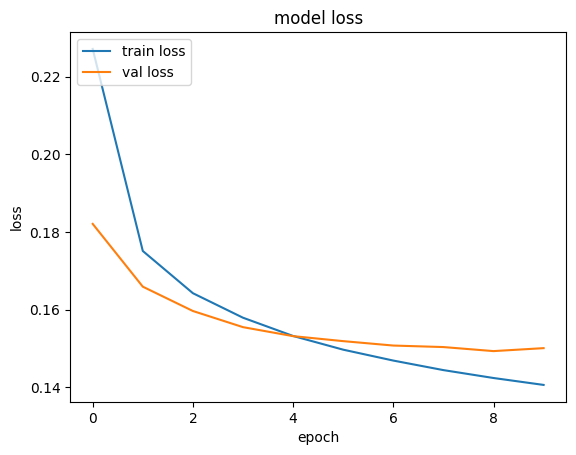

In [15]:
# summarize history for loss
import matplotlib.pyplot as plt

print(history)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 [==============================] - 1s 2ms/step


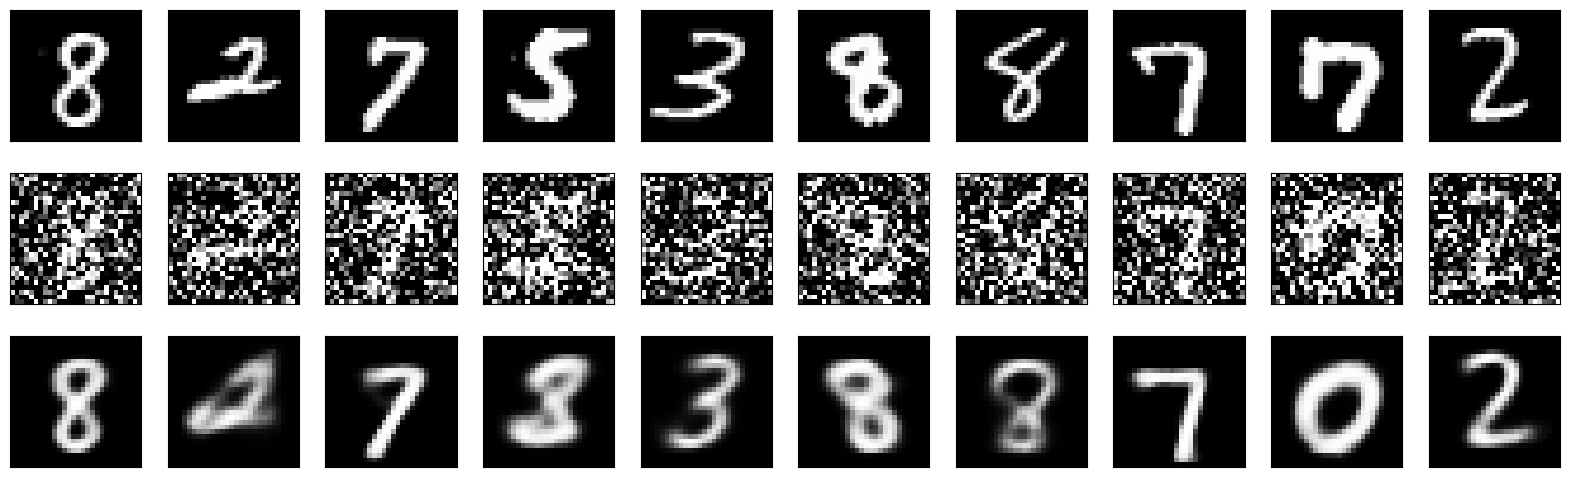

In [16]:
predictions = autoencoder.predict(noisy_test_data)
display3(test_data,noisy_test_data, predictions)

# **Another use of autoencoders: <font color='green'> outliers detection**

The autoencoder training is an unsupervised training which is repeated until the error between original data and decoding data is minimised. This error is called **reconstruction error**.

One of the applications of autoencoders is as a technique to **detect outliers**. Notice that outliers are observations that “stand out” from the norm of a dataset. Then, if the model trains with a given dataset, outliers will be higher reconstruction error, so outliers will be easy to detect by using this neural network.

**Practical case**

Let’s see a toy example of autoencoder as a outliers detector. Imagine we have a dataset of more than 7000 observations. Let’s divide the sample in a training part with 80% of the entries and a test part with 20% of the sample. We assure that in the training dataset there are not any outliers so that the neural network trains only with inliers. Meanwhile, there are only 17 outliers in the test dataset.

The goal is to find the outliers in the test dataset after training with the training dataset. By using an autoencoder, it detects 9 out of 17 real outliers. There are not any false positives, although there are false negatives because some of the outliers have not been found.

<img src='https://quantdare.com/wp-content/uploads/2019/07/example_autoencoder.png' width=500p>

###**Nice article how to detect the outliers using autoencoders:**

https://towardsdatascience.com/outlier-detection-with-autoencoders-6c7ac3e2aa90

<iframe width="560" height="315" src="https://www.youtube.com/embed/n2gE7n11h1Y" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>



---

---

# <font color=green> **Stable diffusion generator**



---



---



Stable Diffusion is a deep learning, text-to-image model released in 2022 based on diffusion techniques. It is considered to be a part of the ongoing artifical intelligence boom.

Stable Diffusion, originated from a project called Latent Diffusion, developed by researchers at Ludwig Maximilian University in Munich and Heidelberg University. 4 of the original 5 authors (Robin Rombach, Andreas Blattmann, Patrick Esser and Dominik Lorenz) later joined Stability AI and released subsequent versions of Stable Diffusion.

*Source: wikipedia*


### Very nice tutorial with examples:
https://scholar.harvard.edu/binxuw/classes/machine-learning-scratch/materials/stable-diffusion-scratch

With more mathematical formalism:

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

# <font color=green> **Quick Overview of Diffusion Models**






To understand how diffusion models work, let’s first look at how they are trained, which is done in a slightly nonintuitive way.

* Begin by applying noise to an image repeatedly, which creates a “Markov chain” of images. In such a way, we are able to get some number *T* of repeatedly more noisy images from a singular original image.

* The model learns to predict the exact noise that was applied at a certain time step, and we can use its output to “denoise” the image at that time step.

* This effectively allows us to go from image T to image T-1 (backward in noise adding chain). The model is trained by giving it the image with noise applied at some time T, and the time T itself, and the output is what **noise** was applied to bring it from time T-1 to T!

* **Image generation**: once such a model is trained, we can **repeatedly apply it to random noise** to produce a new image.

<img src='https://raw.githubusercontent.com/marcinwolter/MachineLearning-KISD-2024/main/images/StableDiffusion.jpg' width=800px>

###**UNet Model**

* **UNet** architecture model is commonly used to predict the noise at each time step.
* This is a type of architecture that repeatedly applies convolutional layers, pooling layers, and skip connections to first downscale an image but increase depth (feature maps), and then transposed convolutions are used to up-sample the feature maps back to the original image dimensions (a little similar to autoencoder).

**To explain U-Net in one sentence, it would be that U-Net is like an encoder-decoder for images, but with skip connections to make sure fine details are not lost. U-Net are used often in many segmentation tasks, and in recent years have made their ways onto image generation tasks as well.**

*For more Unet info see for example:*

*https://towardsdatascience.com/understanding-u-net-61276b10f360*


<img src='https://raw.githubusercontent.com/marcinwolter/MachineLearning-KISD-2024/main/images/Unet.webp' width=800px>

U-Net was developed for the task of semantic segmentation[*].

How to apply the concept of encoder-decoder to images segmentation? We can generate a one-dimensional binary mask and train the network using cross-entropy loss. Our network consists of two parts: the encoder which extracts relevant features from images, and the decoder part which takes the extracted features and reconstructs a segmentation mask.

Because deep neural networks can “forget” certain features as it pass information through successive layers, **skip connections** can reintroduce them to make learning stronger. We can add skip connections to U-Net such that every decoder incorporate the feature map from its corresponding encoder. This is a defining feature of U-Net.

<img src='https://raw.githubusercontent.com/marcinwolter/MachineLearning-KISD-2024/main/images/segmentation.webp' width=800px>

*The task: to segment ellipses and not segment any other shapes.*



---



 *Source: https://towardsdatascience.com/understanding-u-net-61276b10f360*

 [*] Ronneberger O, Fischer P, Brox T (2015). "U-Net: Convolutional Networks for Biomedical Image Segmentation". [arXiv:1505.04597](https://arxiv.org/abs/1505.04597)

##**Text**

How to add the text factor into this?

When training our model, we not only train it to diffuse images (or, more accurately the latent space representations of these images produced by our first model), we also train it to understand the text and use to generate these images.

This is because “cross attention”, the mechanism which allows the model to selectively focus on certain text features or aspects, is built into the model itself.
Our Denoising UNet is fed the text and some random noise (both encoded), and its final output is compared to the original image. The model both learns to use the text effectively and denoise effectively at the same time.

<img src='https://upload.wikimedia.org/wikipedia/commons/f/f6/Stable_Diffusion_architecture.png' width=600px>

#<font color="green"> **Example of stable diffusion code**

Code adapted from: https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb

# Introduction to 🤗 Diffusers

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)

In this notebook, you'll train your first diffusion model to **generate images of cute butterflies 🦋.** Along the way, you'll learn about the core components of the 🤗 Diffusers library, which will provide a good foundation for the more advanced applications that we'll cover later in the course.

Let's dive in!

## What You Will Learn

In this notebook you will:

- See a powerful custom diffusion model pipeline in action (with information on how to make your own version)
- Create your own mini pipeline by:
  - Recapping the core ideas behind diffusion models
  - Loading in data from the Hub for training
  - Exploring how we add noise to this data with a scheduler
  - Creating and training the UNet model
  - Putting the pieces together into a working pipeline
- Edit and run a script for initializing longer training runs, that will handle
  - Multi-GPU training via 🤗 Accelerate
  - Experiment logging to track critical stats
  - Uploading the final model to the Hugging Face Hub

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord

## Step 1: Setup

Finally, let's import the libraries we'll be using and define a few convenience functions which we'll use later in the notebook:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK, we're all set!

Run the following cell to install the diffusers library as well as a few other requirements:

In [2]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## MVP (Minimum Viable Pipeline)

The core API of 🤗 Diffusers is divided into three main components:
1. **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
2. **Models**: popular architectures for training new diffusion models, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: various techniques for generating images from noise during *inference* as well as to generate noisy images for *training*.

Pipelines are great for end-users, but if you're here for this course we assume you want to know what is going on under the hood!

We're training from scratch with a small data sample (1000 images only). Speaking of training, recall from the introduction to this unit that training a diffusion model looks something like this:


1.   Load in some images from the training data
2.   Add noise, in different amounts.
3.   Feed the noisy versions of the inputs into the model
4.   Evaluate how well the model does at denoising these inputs
5.   Use this information to update the model weights, and repeat

We'll explore these steps one by one in the next few sections until we have a complete training loop working, and then we'll explore how to sample from the trained model and how to package everything up into a pipeline for easy sharing. Let's begin with the data...

## Step 2: Download a training dataset

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [3]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can grab a batch of images and view some of them like so:

X shape: torch.Size([8, 3, 32, 32])


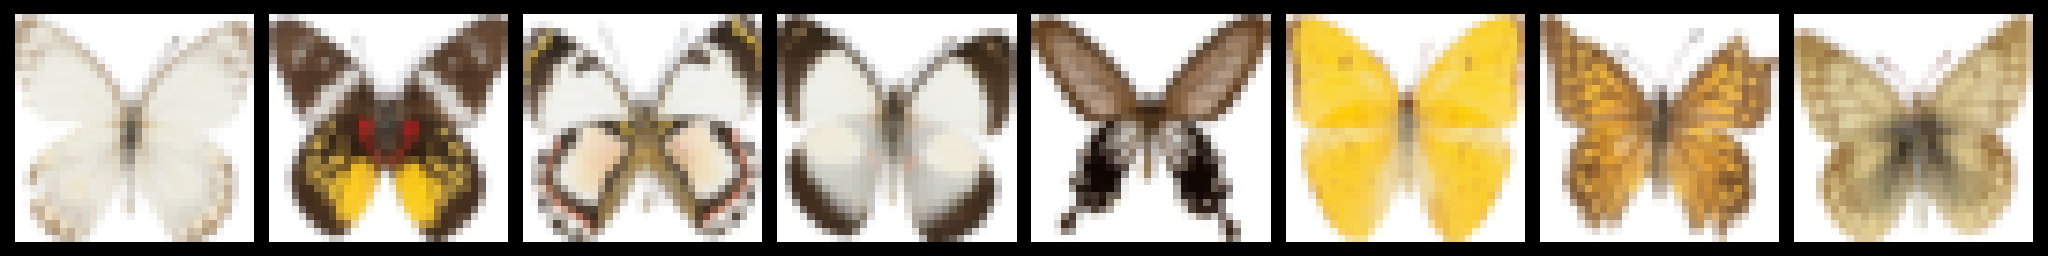

In [4]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 256, 256), resample=Image.NEAREST)

We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Step 3: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are both handled by the **scheduler**.

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):

In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

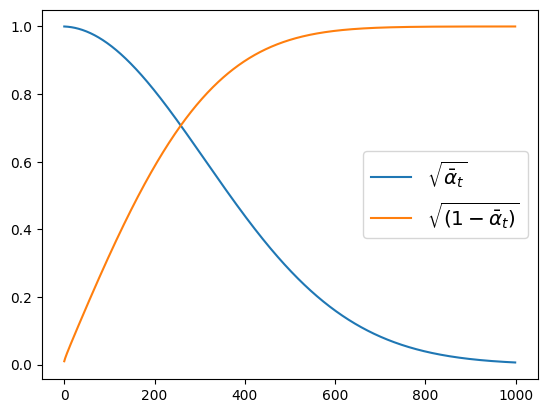

In [6]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**Exercise:** You can explore how this plot changes with different settings for beta_start, beta_end and beta_schedule by swapping in one of the commented-out options here:

In [7]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

Noisy X shape torch.Size([8, 3, 32, 32])


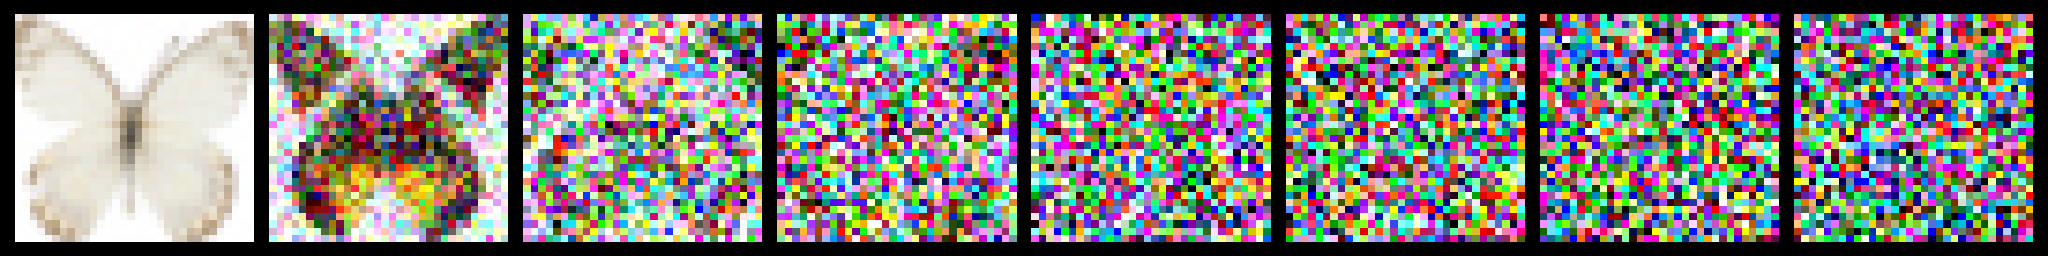

In [8]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 256, 256), resample=Image.NEAREST)

Again, explore the effect of using different noise schedules and parameters here. [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) does a great job explaining some of the maths above in more detail, and is a great introduction to some of these concepts.

## Step 4: Define the Model

Now we come to the core component: the model itself.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [9]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [10]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In the next section we'll see how to train this model.

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004.

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [11]:
from diffusers import DDPMPipeline

In [12]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 1 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

    #if (epoch + 1) % 1 == 0:
    #    image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    #    pipeline_output = image_pipe()
    #    show_images(pipeline_output.images[0]).resize((256, 256), resample=Image.NEAREST)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:1, loss: 0.4568737829104066
Epoch:2, loss: 0.2101304493844509
Epoch:3, loss: 0.18337474390864372
Epoch:4, loss: 0.17104297131299973
Epoch:5, loss: 0.1565262321382761
Epoch:6, loss: 0.13830137439072132
Epoch:7, loss: 0.1410222821868956
Epoch:8, loss: 0.13365112151950598
Epoch:9, loss: 0.11960755800828338
Epoch:10, loss: 0.11941225500777364
Epoch:11, loss: 0.11392540438100696
Epoch:12, loss: 0.10989552550017834
Epoch:13, loss: 0.11288629285991192
Epoch:14, loss: 0.10051435464993119
Epoch:15, loss: 0.10466053243726492
Epoch:16, loss: 0.10676746303215623
Epoch:17, loss: 0.0985878468491137
Epoch:18, loss: 0.09049058659002185
Epoch:19, loss: 0.08797001792117953
Epoch:20, loss: 0.08731227135285735
Epoch:21, loss: 0.08579207118600607
Epoch:22, loss: 0.08568779798224568
Epoch:23, loss: 0.07860392006114125
Epoch:24, loss: 0.08551876060664654
Epoch:25, loss: 0.08207088056951761
Epoch:26, loss: 0.08099178038537502
Epoch:27, loss: 0.07706636376678944
Epoch:28, loss: 0.08464243286289275
Epoch:

Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

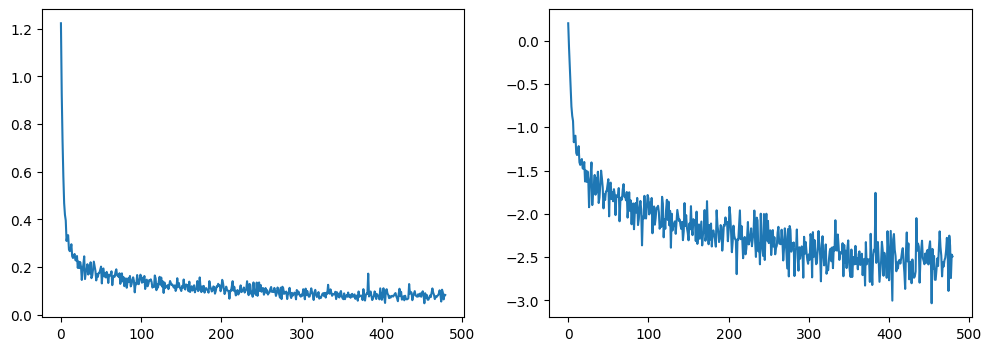

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

As an alternative to running the training code above, you can use the model from the pipeline like so:

In [14]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

How do we get images with this model?

### Option 1: Creating a pipeline:

In [15]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

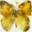

In [16]:
pipeline_output = image_pipe()
pipeline_output.images[0]

We can save a pipeline to a local folder like so:

In [17]:
image_pipe.save_pretrained("my_pipeline")

Inspecting the folder contents:

In [18]:
!ls my_pipeline/

model_index.json  scheduler  unet


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture.

In [19]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.safetensors


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next section.

### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [20]:
# ??image_pipe.forward

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

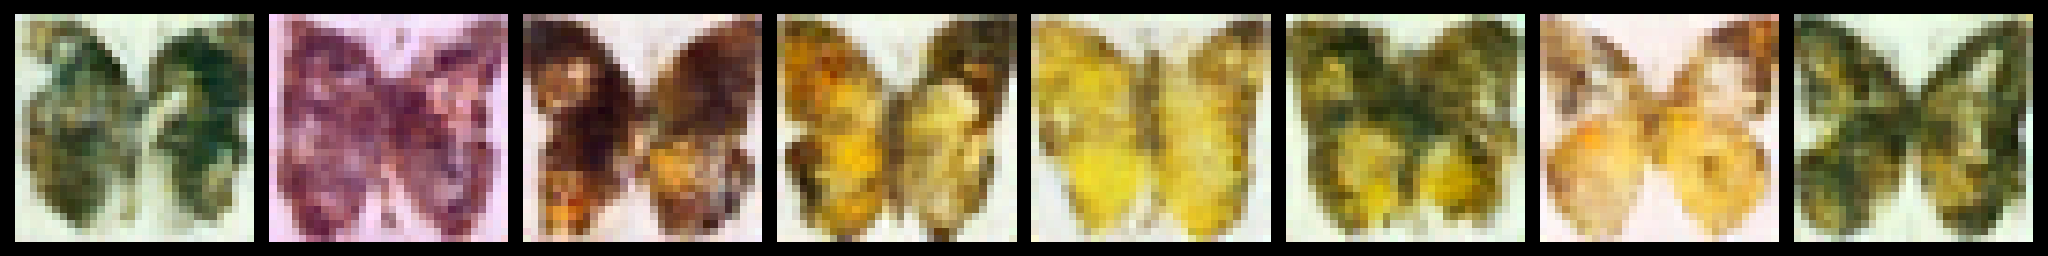

In [21]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((8 * 256, 256), resample=Image.NEAREST)



---



---



---



# **Faces generation**

The same code (updated to generate 128x128 images) used to generate faces:

<img src='https://raw.githubusercontent.com/marcinwolter/MachineLearning-KISD-2024/main/images/original.png' width=800px>

*Original photos*

<img src='https://raw.githubusercontent.com/marcinwolter/MachineLearning-KISD-2024/main/images/generated.png' width=800px>

*Generated photos*

Code: https://github.com/marcinwolter/MachineLearning-KISD-2024/blob/main/01_intro.nbconvert.ipynb

Time: about 12 h.

#<font color='green'> **Summary:**

* **We have learned about new methods:**

  * Deep Neural Networks
  * Data augmentation, knowledge transfer
  * Hyperparameter optimization
  * Transfer learning
  * Reinforcement learning
  * Generative Adversary Networks GAN
  * Autoencoders
  * Stable diffusion generators

* **There are many other Machine Learning techniques like:**
  * Bayesian Neural Networks and Mixture Density Networks MDN returning the probability distribution,
  * Language processing networks (small chatGPT or google translators),
  * recurent networks with memory,
  * and many, many others...

* **Please prepare your projects!!!**  